In [3]:
# Подключаем требуемые библиотеки/модули (достаточно один раз в начале всей программы)
import wget
import math
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [5]:
# Загружаем NetCDF-файлы с метеоданными из облачного хранилища НИВЦ МГУ
# Функция wget.download скачивает файл по ссылке из первого аргумента и записывает его по пути и названию из второго аргумента
print('Loading file 1:')
wget.download('http://kibel.srcc.msu.ru:8080/share.cgi?ssid=2e08fd560c75445eb4944ddb09c2b8b7&openfolder=forcedownload&ep=&_dc=1700580305596&fid=2e08fd560c75445eb4944ddb09c2b8b7&filename=surface_t2m_precip.nc', 
              out = 'surface_t2m_precip.nc')
print('\nLoading file 2:')
wget.download('http://kibel.srcc.msu.ru:8080/share.cgi?ssid=2e08fd560c75445eb4944ddb09c2b8b7&openfolder=forcedownload&ep=&_dc=1700580305596&fid=2e08fd560c75445eb4944ddb09c2b8b7&filename=p-levels_t_u_v_geopotential.nc',
              out = 'p-levels_t_u_v_geopotential.nc')
# Если файл с таким названием в папке назначения уже есть, то новый будет записан с добавкой "(1)" к имени 
# (а если есть и такой, то будет с добавкой "(2)" и т.д.)

Loading file 1:
100% [........................................................................] 12468848 / 12468848
Loading file 2:
100% [........................................................................] 74764060 / 74764060

'p-levels_t_u_v_geopotential.nc'

# Файл №1

In [6]:
# Читаем файл NETCDF
filename = 'surface_t2m_precip.nc'
dataset = nc.Dataset(filename)

# Выводим информацию о файле - нам важно, какие есть параметры и какая у них размерность (какие есть координаты)
print(dataset)

# Ниже мы видим, что у данных в файле есть три координаты: долгота (1440 точек), широта (721 точка) и время (3 точки).
# В файл записаны следующие параметры: долгота (longitude), широта (latitude), время (time), 
# температура воздуха на 2 метрах (t2m) и сумма осадков (tp).
# В скобках после названия параметра указано, какие координаты есть у данного параметра. 
# Например, долгота меняется только вдоль долготы и больше ни от чего не зависит, а значение температуры
# зависит от времени, широты и долготы. 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-10-17 17:25:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data7/adaptor.mars.internal-1666027521.3720944-24283-5-e43f74d6-0a7b-4f77-a8c1-2d93c086b65e.nc /cache/tmp/e43f74d6-0a7b-4f77-a8c1-2d93c086b65e-adaptor.mars.internal-1666027520.3152573-24283-7-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), time(3)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [7]:
# Также мы можем вывести свойства для определённого параметра - какие у него единицы измерения (units), 
# полное название (long_name), какой размер по каждой из координат имеют данные (shape)
print(dataset['time'])
print('\n')
print(dataset['t2m'])

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of -2147483647 used


<class 'netCDF4._netCDF4.Variable'>
int16 t2m(time, latitude, longitude)
    scale_factor: 0.0016584908758695523
    add_offset: 260.26215598405423
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: 2 metre temperature
unlimited dimensions: 
current shape = (3, 721, 1440)
filling on


In [8]:
# Файл мы уже прочитали - теперь возьмём из него конкретные параметры.
lats = dataset['latitude'][:]
lons = dataset['longitude'][:]
time = dataset['time'][:]

# Выражение [:] после скобок с названием параметра нужны для указания, хотим ли мы взять данные для всех
# значений координат или только для определённых. Примеры для параметра t2m:
# [:] - для всех значений координат. 
# [0, 2:5, 0:100] - для 0-ой точки во времени, для точек широты со 2-ой по 4-ую включительно, для точек долготы с 0-ой по 99-ую включительно
data_t2m = dataset['t2m'][:]
# В прочитанном файле ещё есть параметр "сумма осадков", но нам он сейчас не нужен, поэтому мы не стали сохранять его в переменную

# Сохранив параметры в переменные, можем проверить размерности полученных данных:
print('Latitude shape:', np.shape(lats))
print('Longitude shape:', np.shape(lons))
print('Time shape:', np.shape(time))
print('T2m shape:', np.shape(data_t2m))

Latitude shape: (721,)
Longitude shape: (1440,)
Time shape: (3,)
T2m shape: (3, 721, 1440)


In [9]:
# Также можно вывести и сами переменные
print(time)
# В данном случае видно значения трёх точек во времени, к которым относятся данные из файла. 
# Эти числа - количество часов с момента 1900-01-01 00:00:00.0 в Григорианском календаре

[1064304 1065024 1065768]


In [11]:
# Остальные переменные имеют очень много точек и, следовательно, значений - если мы выведем всю переменную, 
# то получим огромный и неудобный текст. Поэтому лучше вывести данные для конкретных интересующих нас точек.
# Например, посмотрим значения широты, долготы и температуры в крайних точках по широте 
# в пределах одного меридиана в последний из трёх момент времени.
print(f'Northern point: lat = {lats[0]}, lon = {lons[69]}, t = {data_t2m[2, 0, 69]}')
print(f'Southern point: lat = {lats[-1]}, lon = {lons[69]}, t = {data_t2m[2, -1, 69]}')

Northern point: lat = 90.0, lon = 17.25, t = 273.0640470548913
Southern point: lat = -90.0, lon = 17.25, t = 214.47785686479938


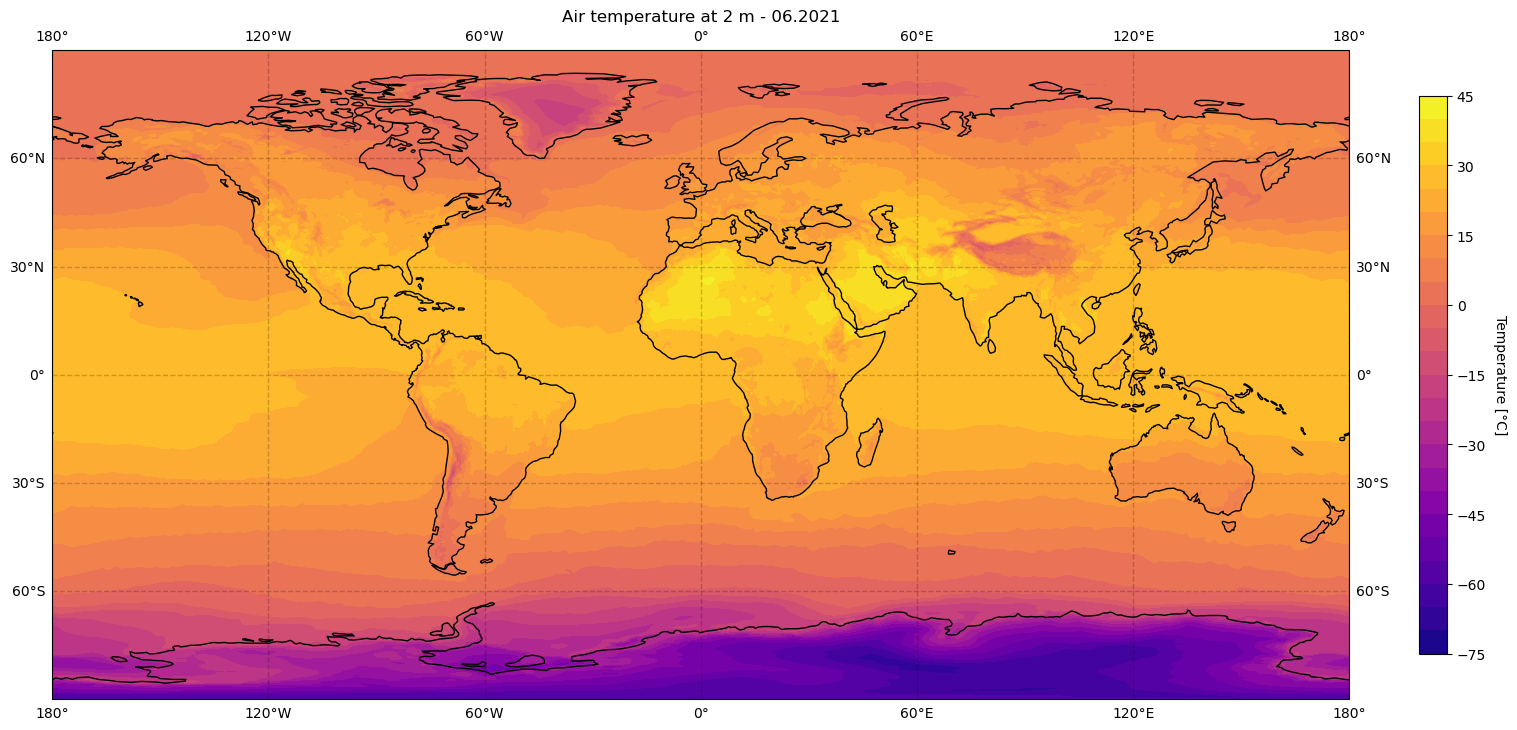

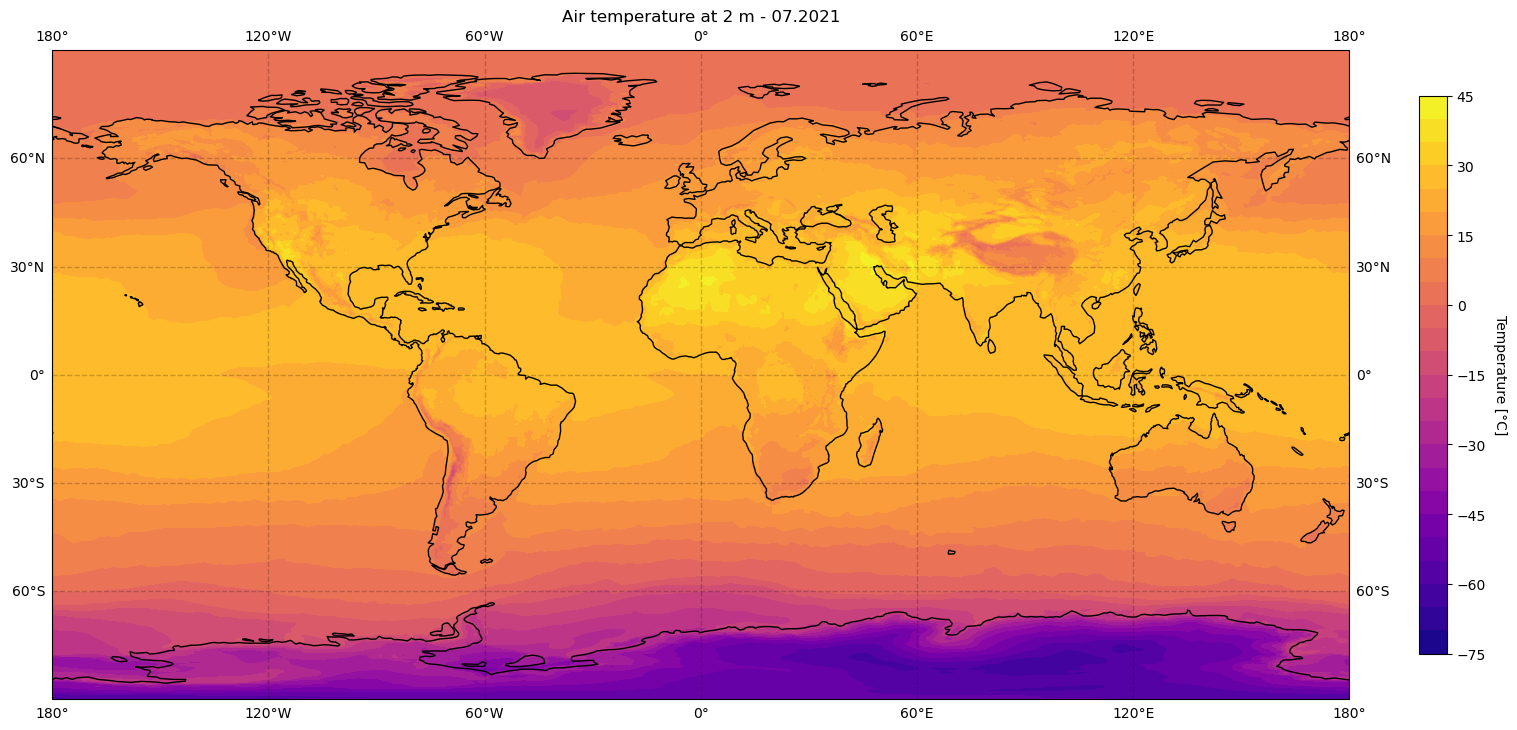

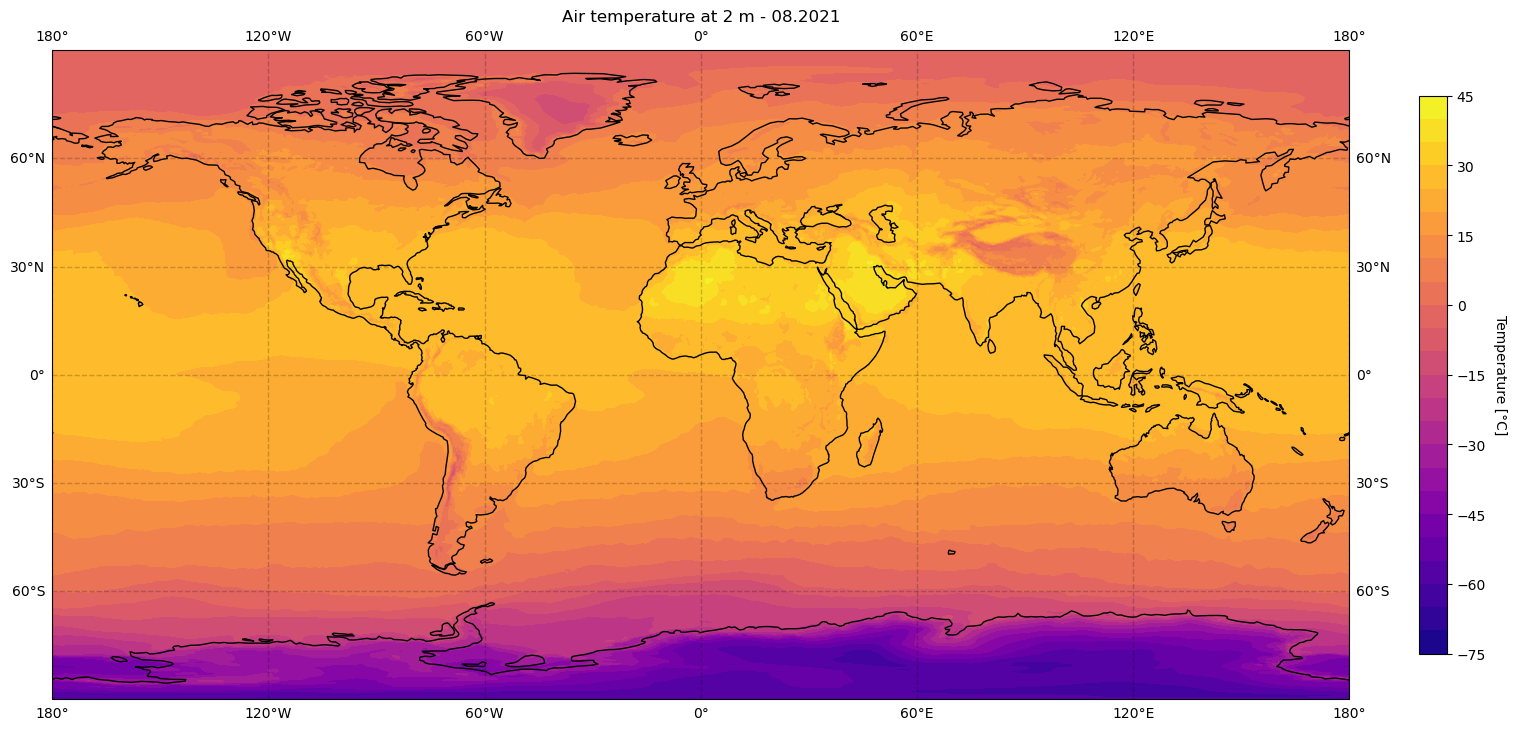

In [58]:
# Теперь построим карты распределения температуры на 2 м для каждого месяца

# Скачиваем данные картографический проекции (в данном случае это проекция Plate Carree)
data_crs = ccrs.PlateCarree()

# Создаём цикл, в котором итератор t_i пройдёт по всем точкам времени - будет меняться от 0 
# до длины массива времени (time) невключительно, то есть примет значения 0, 1 и 2. 
for t_i in range(len(time)):
    # Создаём фигуру с условным размером 18 на 9 - в ней далее будет нарисована карта 
    # Фигуру создавать необязательно, но полезно, если мы хотим выбрать размера рисунка или какие-то другие особенности
    f = plt.figure(figsize = (18, 9))
    # Указываем, что фон фигуры будет белым (по умолчанию он чёрный - при сохранении картинки чёрные надписи были бы не видны)
    f.patch.set_facecolor('white')

    # Создаём координатные оси на основе выбранной проекции
    ax = plt.axes(projection = data_crs)
    # Можем указать границы для рисуемой области карты (но в данном примере нарисуем для всей Земли)
    # ax.set_extent([0, 180, 0, 90], crs = data_crs)

    # Рисуем пространственное распределение температуры с помощью контуров - по определённым значениям проходят линии-контуры,
    # а все значения между ними закрашиваются одним цветом
    # Функция требует указания координат, по которым строятся данные - это lons и lats
    # Также нужны сами данные, причём двумерные, так как это двумерная карта - это срез t2m для определённого момента времени
    # Здесь же мы переводим t2m из Кельвинов в градусы Цельсия, вычитая 273.15
    # levels - это значения, по которым будут проведены контуры
    # transform - данные трансформируются в заданную проекцию
    # cmap - указываем цветовую палитру для данных, в данном случае выбрана одна из стандартных палитр
    plt.contourf(lons, lats, data_t2m[t_i, :, :] - 273.15, levels = range(-75, 50, 5), transform = data_crs, cmap = 'plasma')
    # Рисуем береговые линии
    ax.coastlines()

    # Рисуем координатную сетку и подписи к ней 
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                      linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

    # Рисуем цветовую шкалу, fraction - параметр, определяющий её размер на рисунке
    cbar = plt.colorbar(fraction = 0.02)
    # Указываем сдвиг для названия шкалы, чтобы оно не перекрыло саму шкалу
    cbar.ax.get_yaxis().labelpad = 15
    # Указываем название шкалы и то, что оно должно быть повёрнуто на 270 градусов
    cbar.set_label('Temperature [°C]', rotation = 270)

    # Указываем название всего рисунка (карты), для этого переводим время из netcdf-файла в удобный формат
    # В python формат timestamp - число секунд с 01.01.1970, а наш формат - число часов с 01.01.1900,
    # поэтому умножаем время на 3600 (число секунд в 1 часе) и вычитаем разницу между точками отсчёта (1970 и 1900)
    delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
    date_raw = datetime.fromtimestamp(int(time[t_i]) * 3600) - delta_epoch
    plt.title(f'Air temperature at 2 m - {date_raw.strftime("%m.%Y")}')

    # Выводим все нарисованные части в фигуру - рисунок закончен
    plt.show()
    # Дальше в цикле t_i станет на 1 больше и аналогичный рисунок будет построен для следующего месяца 
    # (если это был не последний)

# Сохранить рисунки в виде файлов можно, наведя мышку на левый нижний угол рисунка - там нажать на кнопку с тремя точками
# и "save image as" или "сохранить картинку как"

# Файл №2

In [27]:
# Теперь проделаем похожие действия для второго файла - в нём больше параметров и уже 4 координаты, а не 3 
# (добавилось давление - вертикальная координата)

filename = 'p-levels_t_u_v_geopotential.nc'
dataset = nc.Dataset(filename)
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-10-17 17:28:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data2/adaptor.mars.internal-1666027703.1958625-30550-12-dfaebb73-4318-41f5-8948-e364183edefd.nc /cache/tmp/dfaebb73-4318-41f5-8948-e364183edefd-adaptor.mars.internal-1666027700.738271-30550-14-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), level(3), time(3)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 level(level), int32 time(time), int16 z(time, level, latitude, longitude), int16 t(time, level, latitude, longitude), int16 u(time, level, latitude, longitude), int16 v(time, level, latitude, longitude)
    groups: 


In [28]:
# Как видно на примере u-компоненты скорости ветра, метеорологические параметры в этом файле имеют 4 координаты:
# 3 точки по времени, 3 точки по давлению (по высоте), 721 точку по широте, 1440 точек по долготе
print(dataset['u'])

<class 'netCDF4._netCDF4.Variable'>
int16 u(time, level, latitude, longitude)
    scale_factor: 0.0006946431408633103
    add_offset: 1.307658965050662
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: U component of wind
    standard_name: eastward_wind
unlimited dimensions: 
current shape = (3, 3, 721, 1440)
filling on


In [29]:
# Прочитаем уже сами данные, нас интересуют U и V
lats = dataset['latitude'][:]
lons = dataset['longitude'][:]
time = dataset['time'][:]
p_level = dataset['level'][:]

data_u = dataset['u'][:]
data_v = dataset['v'][:]

In [30]:
# Проверим уровни давления и узнаем, в каком они порядке
print(p_level)

[ 700  850 1000]


In [31]:
# Мы хотим построить карты полной скорости ветра (модуля скорости ветра), поэтому надо её рассчитать
# Сделать это можно двумя способами:

# 1. Самый простой и самый быстрый - рассчитать сразу для всех значений массивов U и V
# Это возможно, так как U и V имеют одинаковые размеры - одинаковое количество значений по каждой из координат
# Следовательно, каждому значению U однозначно соответствует одно значение V с теми же координатами (и наоборот)

data_windspeed_1 = np.sqrt(data_u ** 2 + data_v ** 2) # - да, всего одной строчкой :)

# 2. Более сложный, более медленный, но зато как угодно настраиваемый - рассчитать с помощью цикла или нескольких циклов, 
# по очереди рассчитывая значений для определённых или для всех координат
# Это может быть полезно, если нет однозначного соответсвия параметров или требуются сложные вычисления, 
# например V для каждой точки берётся как среднее значение от ряда измерений из ближайшей станции (которую ещё надо определить)

# Сначала создадим массив такого же размера, как U и V, заполнив его нулями (можно заполнить значениями "Not a number" и т.д.)
data_windspeed_2 = np.zeros(np.shape(data_u))
# Теперь в циклах по каждой из координат рассчитаем модуль скорости ветра
for t_i in range(len(time)):
    for p_i in range(len(p_level)):
        for lat_i in range(len(lats)):
            for lon_i in range(len(lons)):
                # Здесь можно использовать и math.sqrt, и np.sqrt, потому что первая работает только для одного значения, 
                # а вторая и для одного значения, и для массивов
                data_windspeed_2[t_i, p_i, lat_i, lon_i] = math.sqrt(data_u[t_i, p_i, lat_i, lon_i] ** 2 +
                                                                         data_v[t_i, p_i, lat_i, lon_i] ** 2)

# Видно, что второй способ гораздо длиннее и медленнее, но иногда он может пригодиться

# При этом в данном случае оба способа эквивалентны - проверить это можно, найдя уникальные значения разницы между ними
print(np.unique(data_windspeed_1 - data_windspeed_2))
# Уникальное значение разницы между данными только одно - ноль, значит, значения во всех точках совпадают

[0.0]


In [33]:
# Теперь рассчитаем среднюю скорость ветра за всё лето - для этого надо осреднить данные по координате времени
# Время - первая координата, но так как отсчёт идет с нуля, ось времени имеет индекс 0
data_windspeed_summer_mean = np.mean(data_windspeed_1, axis = 0)

# Проверим, что теперь у средней скорости ветра только 3 координаты: давление, широта и долгота
print(np.shape(data_windspeed_summer_mean))
# Всё правильно, осреднение проведено только по времени

(3, 721, 1440)


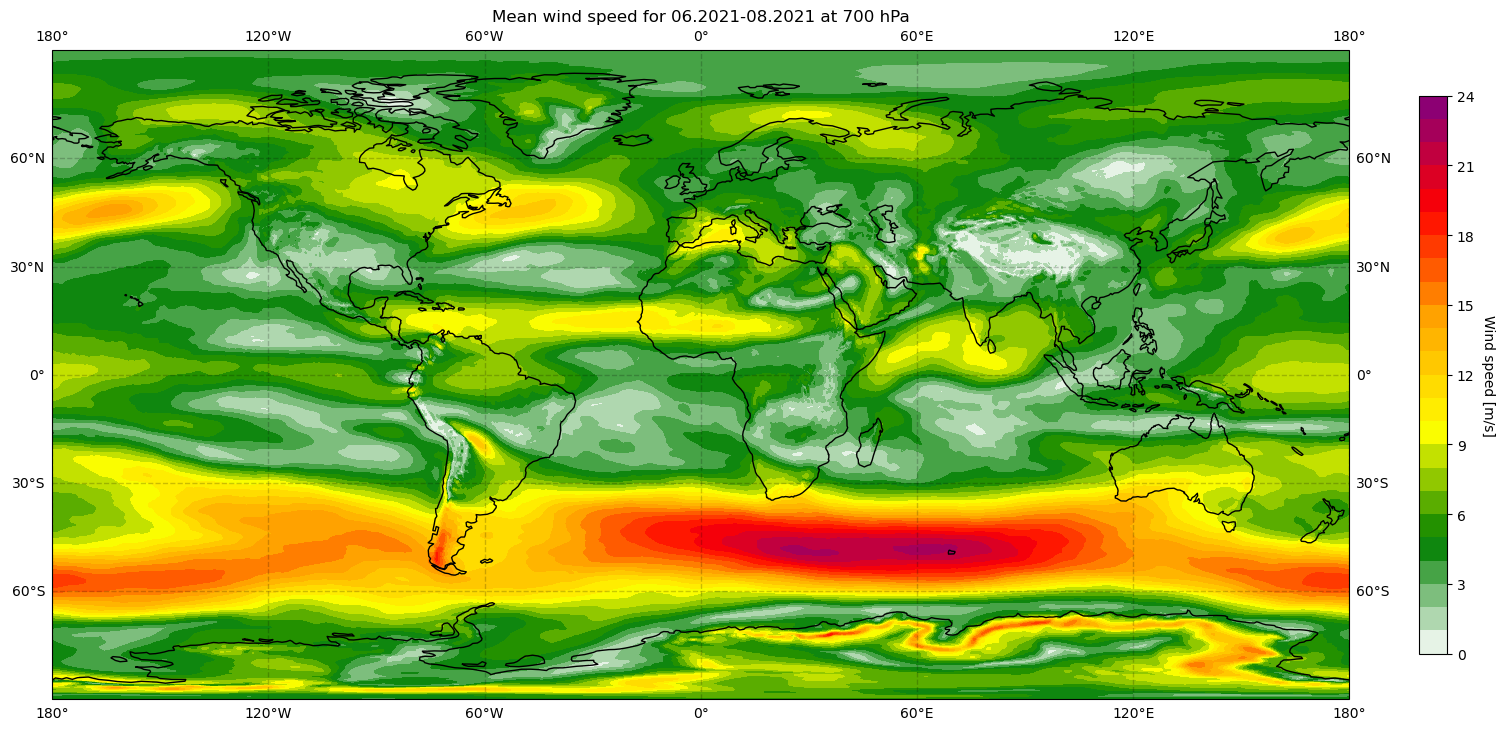

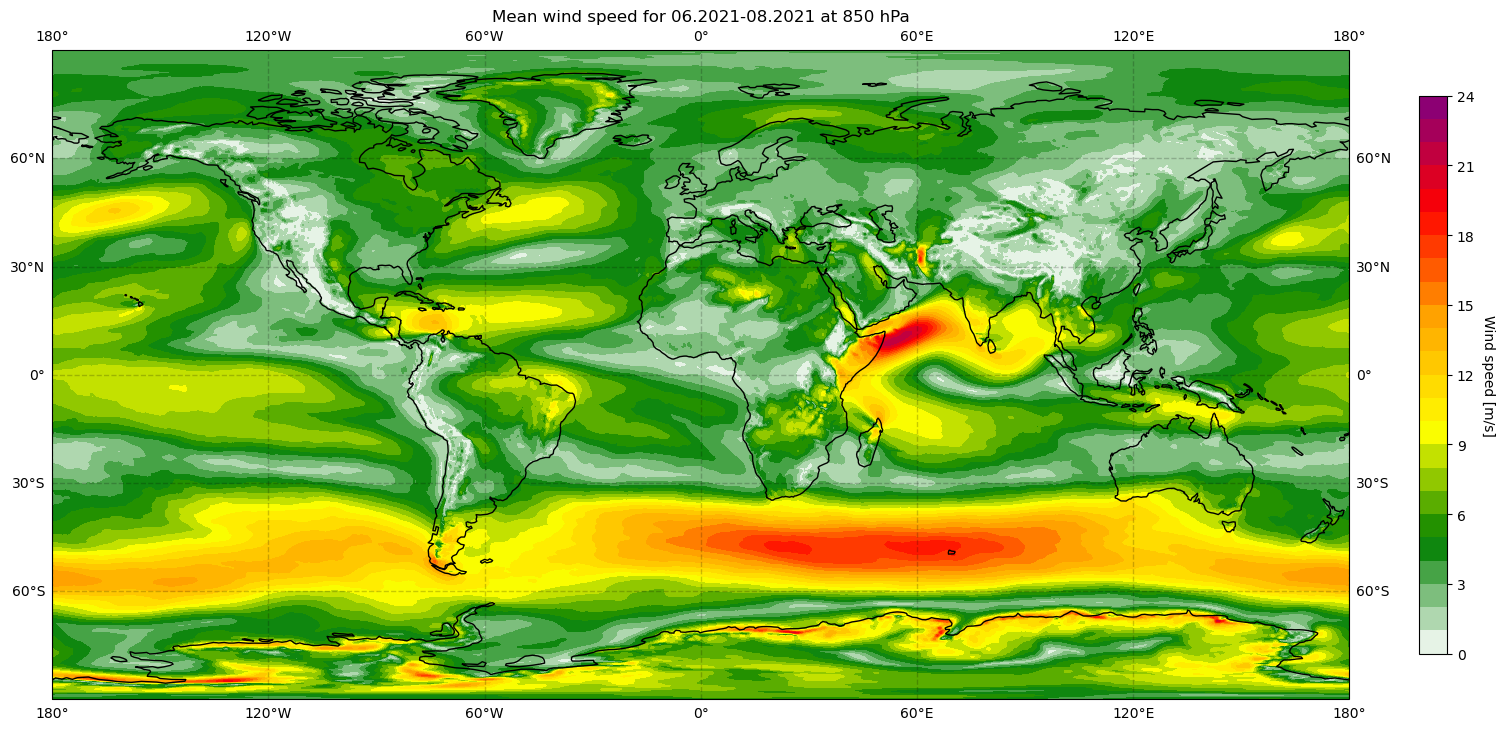

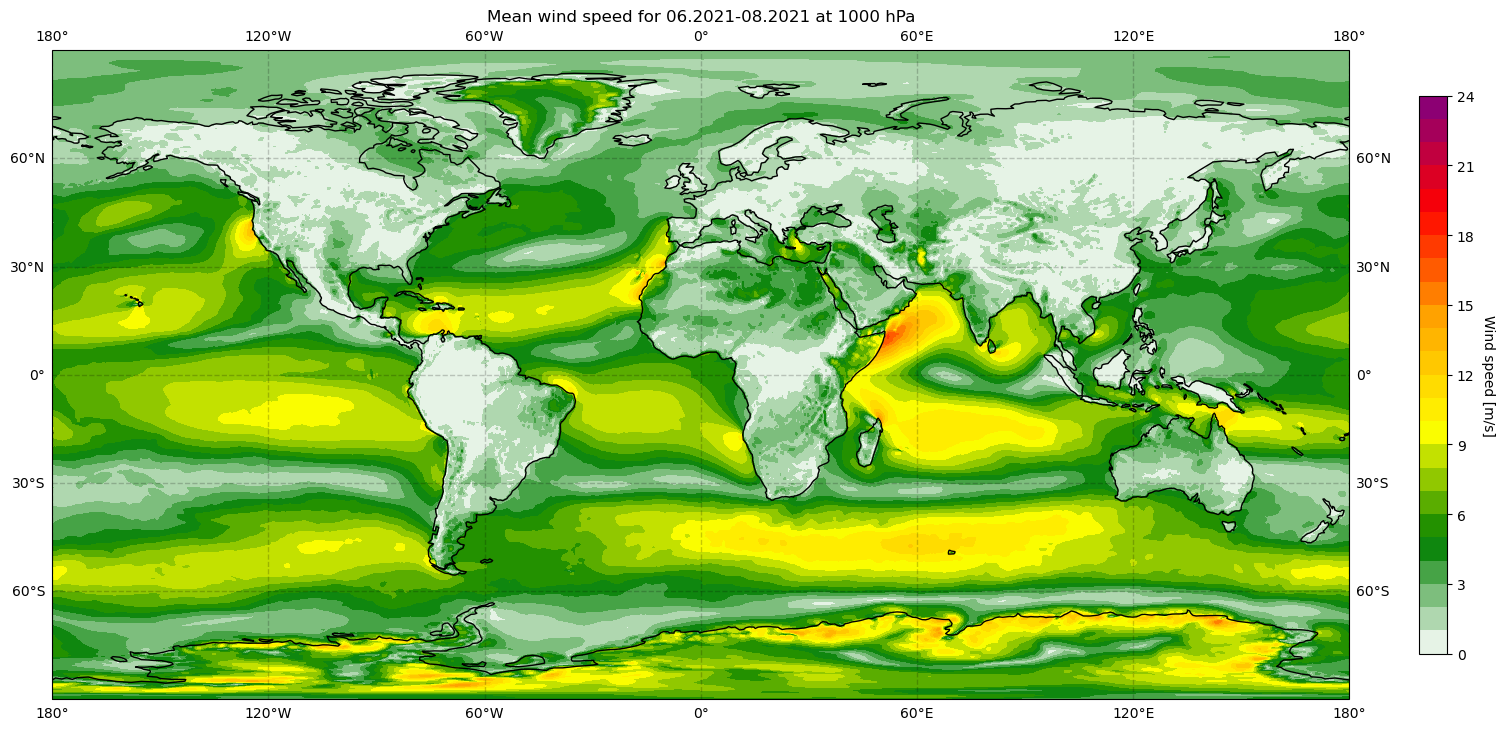

In [35]:
# Теперь построим карты средней за лето скорости ветра для каждой из высот (уровней давления)

data_crs = ccrs.PlateCarree()

# Можем создать собственную цветовую палитру для карт, выбрав нужные цвета и их порядок
newcmp = LinearSegmentedColormap.from_list('', ['white', 'green', 'yellow', 'orange', 'red', 'purple'])

# Создаём цикл, в котором итератор p_i пройдёт по всем уровням давления - будет меняться от 0 
# до длины массива уровней давления (p_level) невключительно, то есть примет значения 0, 1 и 2. 
for p_i in range(len(p_level)):
    f = plt.figure(figsize = (18, 9))
    f.patch.set_facecolor('white')

    ax = plt.axes(projection = data_crs)
    # Можем указать границы для рисуемой области карты (но в данном примере нарисуем для всей Земли)
    # ax.set_extent([0, 180, 0, 90], crs = data_crs)

    plt.contourf(lons, lats, data_windspeed_summer_mean[p_i, :, :], levels = range(0, 25, 1), transform = data_crs, cmap = newcmp)
    ax.coastlines()

    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                      linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

    cbar = plt.colorbar(fraction = 0.02)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.set_label('Wind speed [m/s]', rotation = 270)

    delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
    date_start = datetime.fromtimestamp(int(time[0]) * 3600) - delta_epoch
    date_end = datetime.fromtimestamp(int(time[-1]) * 3600) - delta_epoch
    plt.title(f'Mean wind speed for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")} at {p_level[p_i]} hPa')

    plt.show()
    

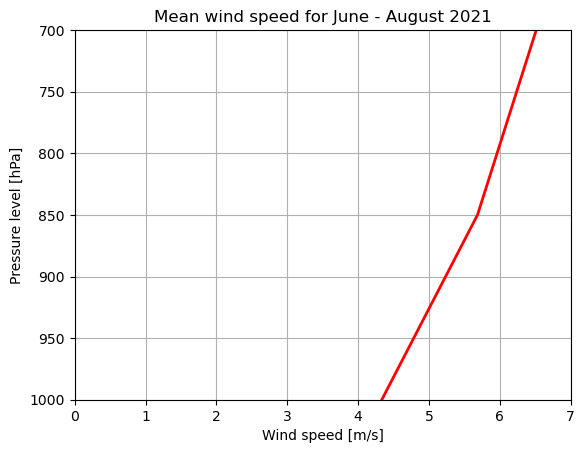

In [37]:
# В качестве последнего примера построим зависимость скорости ветра от высоты (уровня давления) в среднем
# за всё лето по всем широтам и долготам
wind_monthly_mean = np.mean(data_windspeed_1, axis = (0, 2, 3))

# Построим график месячного хода
plt.plot(wind_monthly_mean, p_level, linewidth = 2, color = 'red')

# Выставим границы области рисования
plt.ylim([1000, 700]) # Границы для графика по оси Y указаны в обратном порядке, потому что нам нужно перевернуть ось
                      # (иначе высокое давление будет наверху, а низкое внизу)
plt.xlim([0, 7])
plt.ylabel('Pressure level [hPa]')
plt.xlabel('Wind speed [m/s]')
plt.title('Mean wind speed for June - August 2021')

# Рисуем сетку координат на графике
plt.grid()

plt.show()

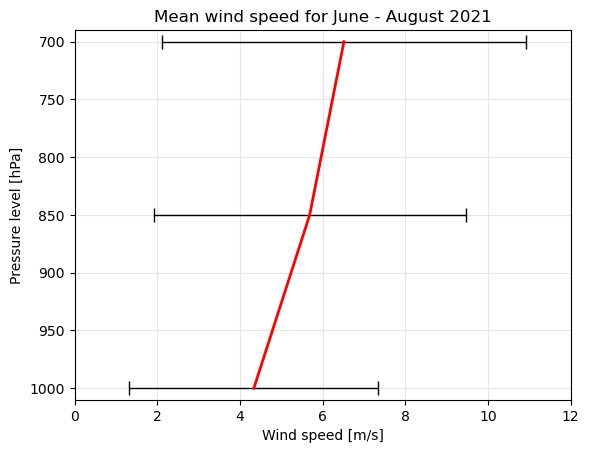

In [55]:
# Построим теперь такой же график, но с оценкой разброса скоростей ветра по высотам
# Для оценки разброса значений посчитаем ещё стандартное отклонение (СКО)
wind_monthly_std = np.std(data_windspeed_1, axis = (0, 2, 3))

# График с "усами" стандартного отклонения нарисуем другой функцией:
plt.errorbar(wind_monthly_mean, p_level, xerr = wind_monthly_std, ecolor = 'black', elinewidth = 1, capsize = 5, linewidth = 2, color = 'red')

# Границы области рисования сделаем шире, чтобы "усы" поместились 
plt.ylim([1010, 690])
plt.xlim([0, 12])

plt.ylabel('Pressure level [hPa]')
plt.xlabel('Wind speed [m/s]')
plt.title('Mean wind speed for June - August 2021')
# Сделаем сетку светлее, чтобы она не мешала "усам"
plt.grid(color = (0.9, 0.9, 0.9))

plt.show()